In [21]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from datetime import timedelta
%matplotlib inline

In [22]:
mnist = input_data.read_data_sets('data/MNIST',one_hot=True)

Extracting data/MNIST\train-images-idx3-ubyte.gz
Extracting data/MNIST\train-labels-idx1-ubyte.gz
Extracting data/MNIST\t10k-images-idx3-ubyte.gz
Extracting data/MNIST\t10k-labels-idx1-ubyte.gz


In [23]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = sess.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [24]:
#Hyper Parameters and Structure
# input > conv > relu > max pooling > flattened > fully connected > sigmoid

batchSize = 64 #number of examples to use during training

numberOfImages = 55000
imgSize = 28
imgShape = (imgSize,imgSize)
imgShapeFlat = imgSize*imgSize

filterSize1 = 5
filterShape1 = (filterSize1,filterSize1)
filterShapeFlat1 = filterSize1*filterSize1
numberOfFilters1 = 16

filterSize2 = 5
filterShape2 = (filterSize2,filterSize2)
filterShapeFlat2 = filterSize2*filterSize2
numberOfFilters2 = 36

stride = (1,1) # y then x
strideShape = [1,stride[0],stride[1],1] #1s on sides are for image number and channel respectively

poolingStride = (2,2)
poolingStrideShape = [1,poolingStride[0],poolingStride[1],1]

numberOfChannels = 1 #this is the color depth. greyscale is 1, rgb is 3 etc. What is binary? probably 1

fcSize = 128

initSeed = tf.set_random_seed(420)

In [25]:
trainingData = mnist.train.images.reshape(numberOfImages,imgSize,imgSize,numberOfChannels)

In [26]:
mnist.train.labels.shape

(55000, 10)

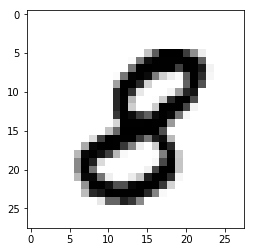

In [27]:
plt.imshow(trainingData[5].reshape(imgShape),cmap='binary')

In [28]:
with tf.name_scope('Input'):
    x = tf.placeholder(tf.float32,[None,28,28,1])
with tf.name_scope('Output'):
    y = tf.placeholder(tf.float32,[None,10])

In [29]:
with tf.name_scope('Convolution1'):
    with tf.name_scope('Filters1'):
        filters1 = tf.Variable(tf.random_normal([filterSize1,filterSize1,numberOfChannels,numberOfFilters1],seed=initSeed))
    activationMap1 = tf.nn.conv2d(x,filters1,strideShape,'SAME')

In [30]:
with tf.name_scope('MaxPooling1'):
    maxPoolLayer1 = tf.nn.max_pool(activationMap1,poolingStrideShape,poolingStrideShape,'SAME')

In [31]:
with tf.name_scope('ReLU1'):
    reluLayer1 = tf.nn.relu(maxPoolLayer1)

In [32]:
with tf.name_scope('Convolution2'):
    with tf.name_scope('Filters2'):
        filters2 = tf.Variable(tf.random_normal([filterSize2,filterSize2,numberOfFilters1,numberOfFilters2],seed=initSeed))
    activationMap2 = tf.nn.conv2d(reluLayer1,filters2,strideShape,'SAME')

In [33]:
with tf.name_scope('MaxPooling2'):
    maxPoolLayer2 = tf.nn.max_pool(activationMap2,poolingStrideShape,poolingStrideShape,'SAME')

In [34]:
with tf.name_scope('ReLU2'):
    reluLayer2 = tf.nn.relu(maxPoolLayer2)

In [35]:
with tf.name_scope('Flattening'):
    num_features = reluLayer2.shape[1:4].num_elements() # same as maxPoolLayer.shape[1]*maxPoolLayer.shape[2]*maxPoolLayer.shape[3] but that <- wont work for some reason
    flatLayer = tf.reshape(reluLayer2,[-1,(num_features)])
    print(flatLayer)

Tensor("Flattening_1/Reshape:0", shape=(?, 1764), dtype=float32)


In [36]:
with tf.name_scope('FC'):
    with tf.name_scope('Weights'):
        weights1 = tf.Variable(tf.random_normal([num_features,fcSize],seed=initSeed))
    with tf.name_scope('Biases'):
        biases1 = tf.Variable(tf.random_normal([fcSize],seed=initSeed))
    activity1 = tf.matmul(flatLayer,weights1)
    activation1 = tf.add(activity1,biases1)
    relu1 = tf.nn.relu(activation1)

In [37]:
with tf.name_scope('Output'):
    with tf.name_scope('Weights'):
        weights2 = tf.Variable(tf.random_normal([fcSize,10],seed=initSeed))
    with tf.name_scope('Biases'):
        biases2 = tf.Variable(tf.random_normal([10],seed=initSeed))
    activity2 = tf.matmul(relu1,weights2) + biases2
    #output = tf.nn.relu(activity2)
    yHat = tf.argmax(activity2,dimension=1)

In [38]:
with tf.name_scope('Loss_And_Training'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=activity2,labels=y))
    training = tf.train.AdamOptimizer(0.0001).minimize(loss)
with tf.name_scope('Accuracy'):
    yTrue = tf.argmax(y,dimension=1)
    truthTensor = tf.equal(yHat,tf.cast(yTrue,tf.int64))
    accuracy = tf.reduce_mean(tf.cast(truthTensor, tf.float32))

In [39]:
with tf.name_scope('Init'):
    init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
currentFilters = filters1
#plot_conv_weights(filters)

In [40]:
writer = tf.summary.FileWriter("C:/Users/Preston/Anaconda3/envs/tensorflow/tensorboard_graphs", sess.graph)
startTime = time.time()
for i in range(0,2600):
    xBatch, yBatch = mnist.train.next_batch(batchSize)
    xBatch = xBatch.reshape(batchSize,28,28,1)
    
    xTestBatch, yTestBatch = mnist.test.next_batch(batchSize)
    xTestBatch = xTestBatch.reshape(batchSize,28,28,1)
    
    sess.run(training,{x:xBatch,y:yBatch})
    
    if i % 200 == 0:
        print('Iteration:',i,'Current Accuracy:',sess.run(accuracy,{x:xTestBatch,y:yTestBatch})*100,'%','Time Elapsed:',timedelta(seconds=int(round(time.time()-startTime))))

Iteration: 0 Current Accuracy: 6.25 % Time Elapsed: 0:00:00
Iteration: 200 Current Accuracy: 20.3125 % Time Elapsed: 0:00:25
Iteration: 400 Current Accuracy: 40.625 % Time Elapsed: 0:00:50
Iteration: 600 Current Accuracy: 59.375 % Time Elapsed: 0:01:20
Iteration: 800 Current Accuracy: 59.375 % Time Elapsed: 0:01:46
Iteration: 1000 Current Accuracy: 60.9375 % Time Elapsed: 0:02:13
Iteration: 1200 Current Accuracy: 70.3125 % Time Elapsed: 0:02:39
Iteration: 1400 Current Accuracy: 67.1875 % Time Elapsed: 0:03:04
Iteration: 1600 Current Accuracy: 81.25 % Time Elapsed: 0:03:29
Iteration: 1800 Current Accuracy: 78.125 % Time Elapsed: 0:03:53
Iteration: 2000 Current Accuracy: 71.875 % Time Elapsed: 0:04:19
Iteration: 2200 Current Accuracy: 85.9375 % Time Elapsed: 0:04:45
Iteration: 2400 Current Accuracy: 78.125 % Time Elapsed: 0:05:10


In [41]:
errors = 0
for i in range(0,mnist.test.labels.shape[0]):
    prediction = int(sess.run(yHat,{x:mnist.test.images[i:i+1].reshape(1,28,28,1)}))
    if np.argmax(mnist.test.labels[i]) != prediction:
        errors += 1
print((1-(errors/mnist.test.labels.shape[0]))*mnist.test.labels.shape[0])

8137.0


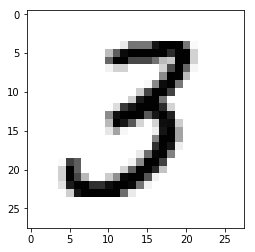

In [42]:
plt.imshow(mnist.test.images[i].reshape(imgShape),cmap='binary')

In [43]:
print(np.argmax(mnist.test.labels[i]))

3
